# Regression Open-Ended Project

-----

# Define Question / Hypothesis

**Use publicly available data to generate Roger Ebert-esque ratings for recent movies.**

In [241]:
import warnings
warnings.filterwarnings('ignore')

# Obtain Data via Scraping and APIs

- time: to add in a sleep delay when scraping
- tqdm: a nifty tool to show progress bar

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import tqdm
import pickle
import re
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Scraping

- Manual - download website files locally
- Procedural - find AJAX script
- Pythonic - headless browswer with Selenium

In [13]:
def scrape_eberts_review(num_pages=100):
    """
    Parses through webpage with list of movies and returns DataFrame.
    :num_pages = Number of pages to go through
    """
    url = "http://www.rogerebert.com/reviews?great_movies=0&no_stars=0&title=Cabin+in+the+Woods&filtersgreat_movies%5D%5B%5D=&filters%5Bno_stars%5D%5B%5D=&filters%5Bno_stars%5D%5B%5D=1&filters%5Btitle%5D=&filters%5Breviewers%5D=&filters%5Bgenres%5D=&page={}&sort%5Border%5D=newest"
    pages = list(range(1, num_pages))
    links = [url.format(i) for i in pages]
    
    review_list = list()
    
    for link in links:
        webpage = requests.get(link).text
        soup = BeautifulSoup(webpage, 'lxml')
        all_movies = soup('figure', {'class':'movie review'})
    
        for movie in all_movies:
            url = movie.a.get('href')
            title = movie.find_all('a')[1].text
            stars = len(movie.find_all('i', {'class':'icon-star-full'})) + 0.5 * len(movie.find_all('i', {'class':'icon-star-half'}))

            try:
                year = movie.find('span', {'class':'release-year'}).text[1:-1]
            except:
                year = ''

            review_list.append([title, stars, year, url])
    
    df = pd.DataFrame(review_list, columns = ['Title', 'EbertStars', 'Year', 'URL'])
    return df

In [20]:
review_df = scrape_eberts_review(num_pages=400)

In [21]:
print(review_df.shape)
print(review_df.dtypes)
print(review_df.head())
print(review_df.tail())

(9212, 4)
Title          object
EbertStars    float64
Year           object
URL            object
dtype: object
                 Title  EbertStars  Year                                URL
0  A Cure for Wellness         2.0  2017  /reviews/a-cure-for-wellness-2017
1      Big Little Lies         3.5  2017      /reviews/big-little-lies-2017
2       The Great Wall         3.0  2017       /reviews/the-great-wall-2017
3       American Fable         3.0  2017       /reviews/american-fable-2017
4             Lovesong         3.0  2017             /reviews/lovesong-2017
                       Title  EbertStars  Year  \
9207    Bang the Drum Slowly         4.0  1973   
9208        Visions of Eight         3.0  1973   
9209      The Mackintosh Man         1.5  1973   
9210  Jesus Christ Superstar         3.0  1973   
9211       American Graffiti         4.0  1973   

                                       URL  
9207    /reviews/bang-the-drum-slowly-1973  
9208        /reviews/visions-of-eight-197

In [24]:
def scrape_webpage(link):
    """
    Parses each individual review page and returns list of key attributes.
    :link = URL for review
    """
    link = "http://www.rogerebert.com" + link
    webpage = requests.get(link).text
    soup = BeautifulSoup(webpage, 'lxml')

    try:
        mpaa = soup.find('p', {'class':'mpaa-rating'}).strong.text[6:]
    except:
        mpaa = ''

    try: 
        runningtime = int(soup.find('p', {'class':'running-time'}).strong.text[:3].strip())
    except:
        runningtime = ''

    try:
        genres = soup.find('p', {'class':'genres'}).strong.text.replace(',', '').split()
    except:
        genres = []

    try:
        reviewbody = ' '.join([paragraph.text for paragraph in soup.find('div', {'itemprop':'reviewBody'}).find_all('p')])
    except:
        reviewbody = ''
    
    return [link, mpaa, runningtime, reviewbody]

In [27]:
scraped_list = list()

for movie in tqdm.tqdm(review_df['URL']):
    scraped_list.append(scrape_webpage(movie))
    time.sleep(0.5)

review_content = pd.DataFrame(scraped_list, columns = ['URL', 'Rating', 'Runtime', 'Review'])


100%|██████████| 9212/9212 [1:54:47<00:00,  1.34it/s]


In [28]:
review_content.head()

,URL,Rating,Runtime,Review
0,http://www.rogerebert.com//reviews/a-cure-for-...,R,146,I keep forgetting the title of “A Cure for Wel...
1,http://www.rogerebert.com//reviews/big-little-...,NR,420,"HBO’s excellent “Big Little Lies,” based on th..."
2,http://www.rogerebert.com//reviews/the-great-w...,PG-13,103,"Chinese/American co-produced action-fantasy ""T..."
3,http://www.rogerebert.com//reviews/american-fa...,NR,96,11-year-old Gitty (Peyton Kennedy) listens as ...
4,http://www.rogerebert.com//reviews/lovesong-2017,NR,85,Whether you find “Lovesong” refreshingly coy a...


In [29]:
pickle.dump(review_df, open('ebert_reviews_v2.pkl', 'wb'))
pickle.dump(review_content, open('review_content_v2.pkl', 'wb'))

In [2]:
review_df = pickle.load(open('ebert_reviews_v2.pkl', 'rb'))
review_content = pickle.load(open('review_content_v2.pkl', 'rb'))

In [6]:
review_df.head()

,Title,EbertStars,Year,URL
0,A Cure for Wellness,2.0,2017,/reviews/a-cure-for-wellness-2017
1,Big Little Lies,3.5,2017,/reviews/big-little-lies-2017
2,The Great Wall,3.0,2017,/reviews/the-great-wall-2017
3,American Fable,3.0,2017,/reviews/american-fable-2017
4,Lovesong,3.0,2017,/reviews/lovesong-2017


In [5]:
def scrape_imdb_listing(df):
    """
    Searches IMDB, parses results and returns DataFrame.
    :df = DataFrame with movie titles
    """
    movie_list = list()

    for movie in tqdm.tqdm(df['Title']):
        base_url = 'http://www.imdb.com/find?q='
        url = base_url + movie +'&s=all'
        webpage = requests.get(url).text
        soup = BeautifulSoup(webpage, 'lxml')

        try:
            results = soup('table', {'class':'findList'})[0]
        except:
            continue
            
        title = results.find_all('tr')[0]
        link = title.find('a', href=True)['href']

        url = 'http://www.imdb.com' + link
        webpage = requests.get(url).text
        soup = BeautifulSoup(webpage, 'lxml')

        movie_title = soup.find('title')
        
        try: 
            rate = soup.find('span', itemprop='ratingValue').text
        except:
            rate = ''
        
        try: 
            count = soup.find('span', itemprop='ratingCount').text
        except:
            count = ''
        
        try: 
            des = soup.find('meta',{'name':'description'})['content']
        except:
            des = ''
        
        try: 
            metascore = soup.find('div', class_='metacriticScore').text
        except:
            metascore = ''

        try: 
            reviews_count = soup.find('div', class_='titleReviewbarItemBorder')
            u_reviews = reviews_count.find_all('a')[0].text.split(' ')[0]
            c_reviews = reviews_count.find_all('a')[1].text.split(' ')[0]
        except:
            u_reviews = []
            c_review = []

        try: 
            genre_items = soup.find_all('span', itemprop='genre')
            genre_list = [item.text for item in genre_items]
        except:
            genre_list = []

        try: 
            stars_items = soup.find_all('span', itemprop='actors')
            stars_list = [item.text.strip() for item in stars_items]
        except:
            stars_list = []

        try: 
            director = soup.find('span', itemprop='name').text
        except:
            director = ''

        try: 
            country = soup.find('div', class_='subtext').find_all('a', title=True)[-1].text.split(' ')[-1]
            country = re.sub('[\(\)\{\}<>]', '', country)
        except:
            country = ''
            
        try:
            rel_date = (', ').join(soup.find('div', class_='subtext').find_all('a', 
                                            title=True)[-1].text.split(' ')[:-1])
        except:
            rel_date = ''
    
        movie_list.append([movie, rate, count, des, metascore, u_reviews, c_reviews, 
                       genre_list, stars_list, director, country, rel_date])
        
        time.sleep(0.5)

    
    df = pd.DataFrame(movie_list, columns = ['Title', 'IMDB_Rating', 'Rating_Count', 
        'Description', 'Metascore', 'User_Review_Count', 'Critic_Review_Count',
        'Genre_List', 'Stars_List', 'Director', 'Country', 'Release_Date'])
    return df, movie_list

In [124]:
imdb_listings, temp_list = scrape_imdb_listing(review_df)


100%|██████████| 9212/9212 [4:28:51<00:00,  1.68s/it]


In [125]:
pickle.dump(imdb_listings, open('imdb_listings.pkl', 'wb'))

In [3]:
imdb_listings = pickle.load(open('imdb_listings.pkl', 'rb'))

In [9]:
imdb_listings.head()

,Title,IMDB_Rating,Rating_Count,Description,Metascore,User_Review_Count,Critic_Review_Count,Genre_List,Stars_List,Director,Country,Release_Date
0,A Cure for Wellness,6.6,"1,646","Directed by Gore Verbinski. With Dane DeHaan,...",\n47\n,16,90,"[Mystery, Thriller]","[Dane DeHaan,, Jason Isaacs,, Mia Goth]",Gore Verbinski,USA\n\n,"17, February, 2017"
1,Big Little Lies,,,"With Alexander Skarsgård, James Tupper, Laura ...",,[],90,"[Comedy, Crime, Drama]","[Alexander Skarsgård,, James Tupper,, Laura Dern]",Alexander Skarsgård,\n,"TV, Series, (2017–"
2,The Great Wall,6.3,"14,568","Directed by Yimou Zhang. With Matt Damon, Tia...",\n42\n,96,152,"[Action, Adventure, Fantasy]","[Matt Damon,, Tian Jing,, Willem Dafoe]",Yimou Zhang,USA\n\n,"17, February, 2017"
3,American Fable,6.3,145,Directed by Anne Hamilton. With Peyton Kenned...,\n57\n,1,10,[Thriller],"[Peyton Kennedy,, Richard Schiff,, Kip Pardue]",Anne Hamilton,USA\n\n,"17, February, 2017"
4,Lovesong,6.4,153,"Directed by So Yong Kim. With Riley Keough, J...",\n74\n,3,14,[Drama],"[Riley Keough,, Jena Malone,, Jessie Ok Gray]",So Yong Kim,USA\n\n,"17, February, 2017"


In [10]:
imdb_listings.dtypes

Title                  object
IMDB_Rating            object
Rating_Count           object
Description            object
Metascore              object
User_Review_Count      object
Critic_Review_Count    object
Genre_List             object
Stars_List             object
Director               object
Country                object
Release_Date           object
dtype: object

# Process and Clean Data

In [4]:
review_df = pickle.load(open('ebert_reviews_v2.pkl', 'rb'))

In [12]:
print(review_df.shape)
print(review_df.dtypes)
review_df.head()

(9212, 4)
Title          object
EbertStars    float64
Year           object
URL            object
dtype: object


,Title,EbertStars,Year,URL
0,A Cure for Wellness,2.0,2017,/reviews/a-cure-for-wellness-2017
1,Big Little Lies,3.5,2017,/reviews/big-little-lies-2017
2,The Great Wall,3.0,2017,/reviews/the-great-wall-2017
3,American Fable,3.0,2017,/reviews/american-fable-2017
4,Lovesong,3.0,2017,/reviews/lovesong-2017


In [5]:
def convert_year(row):
    try:
        year = int(row['Year'])
        return year
    except:
        return np.nan

In [6]:
review_df['Year'] = review_df.apply(lambda x: convert_year(x), 1)

In [7]:
review_df.head()

,Title,EbertStars,Year,URL
0,A Cure for Wellness,2.0,2017.0,/reviews/a-cure-for-wellness-2017
1,Big Little Lies,3.5,2017.0,/reviews/big-little-lies-2017
2,The Great Wall,3.0,2017.0,/reviews/the-great-wall-2017
3,American Fable,3.0,2017.0,/reviews/american-fable-2017
4,Lovesong,3.0,2017.0,/reviews/lovesong-2017


In [8]:
print(review_content.shape)
print(review_content.dtypes)
review_content.head()

(9212, 4)
URL        object
Rating     object
Runtime    object
Review     object
dtype: object


,URL,Rating,Runtime,Review
0,http://www.rogerebert.com//reviews/a-cure-for-...,R,146,I keep forgetting the title of “A Cure for Wel...
1,http://www.rogerebert.com//reviews/big-little-...,NR,420,"HBO’s excellent “Big Little Lies,” based on th..."
2,http://www.rogerebert.com//reviews/the-great-w...,PG-13,103,"Chinese/American co-produced action-fantasy ""T..."
3,http://www.rogerebert.com//reviews/american-fa...,NR,96,11-year-old Gitty (Peyton Kennedy) listens as ...
4,http://www.rogerebert.com//reviews/lovesong-2017,NR,85,Whether you find “Lovesong” refreshingly coy a...


In [9]:
def convert_runtime(row):
    try:
        runtime = int(row['Runtime'])
        return runtime
    except:
        return np.nan

In [10]:
review_content['Runtime'] = review_content.apply(lambda x: convert_runtime(x), 1)

In [11]:
review_content['URL'] = review_content['URL'].apply(lambda x: x.replace('http://www.rogerebert.com/', ''))

In [12]:
review_content.head()

,URL,Rating,Runtime,Review
0,/reviews/a-cure-for-wellness-2017,R,146.0,I keep forgetting the title of “A Cure for Wel...
1,/reviews/big-little-lies-2017,NR,420.0,"HBO’s excellent “Big Little Lies,” based on th..."
2,/reviews/the-great-wall-2017,PG-13,103.0,"Chinese/American co-produced action-fantasy ""T..."
3,/reviews/american-fable-2017,NR,96.0,11-year-old Gitty (Peyton Kennedy) listens as ...
4,/reviews/lovesong-2017,NR,85.0,Whether you find “Lovesong” refreshingly coy a...


In [13]:
print(imdb_listings.shape)
print(imdb_listings.dtypes)
imdb_listings.head()

(9194, 12)
Title                  object
IMDB_Rating            object
Rating_Count           object
Description            object
Metascore              object
User_Review_Count      object
Critic_Review_Count    object
Genre_List             object
Stars_List             object
Director               object
Country                object
Release_Date           object
dtype: object


,Title,IMDB_Rating,Rating_Count,Description,Metascore,User_Review_Count,Critic_Review_Count,Genre_List,Stars_List,Director,Country,Release_Date
0,A Cure for Wellness,6.6,"1,646","Directed by Gore Verbinski. With Dane DeHaan,...",\n47\n,16,90,"[Mystery, Thriller]","[Dane DeHaan,, Jason Isaacs,, Mia Goth]",Gore Verbinski,USA\n\n,"17, February, 2017"
1,Big Little Lies,,,"With Alexander Skarsgård, James Tupper, Laura ...",,[],90,"[Comedy, Crime, Drama]","[Alexander Skarsgård,, James Tupper,, Laura Dern]",Alexander Skarsgård,\n,"TV, Series, (2017–"
2,The Great Wall,6.3,"14,568","Directed by Yimou Zhang. With Matt Damon, Tia...",\n42\n,96,152,"[Action, Adventure, Fantasy]","[Matt Damon,, Tian Jing,, Willem Dafoe]",Yimou Zhang,USA\n\n,"17, February, 2017"
3,American Fable,6.3,145,Directed by Anne Hamilton. With Peyton Kenned...,\n57\n,1,10,[Thriller],"[Peyton Kennedy,, Richard Schiff,, Kip Pardue]",Anne Hamilton,USA\n\n,"17, February, 2017"
4,Lovesong,6.4,153,"Directed by So Yong Kim. With Riley Keough, J...",\n74\n,3,14,[Drama],"[Riley Keough,, Jena Malone,, Jessie Ok Gray]",So Yong Kim,USA\n\n,"17, February, 2017"


In [14]:
imdb_listings = pickle.load(open('imdb_listings.pkl', 'rb'))

In [15]:
def convert_imdb_rating(row):
    try:
        rating = float(row['IMDB_Rating'])
        return rating
    except:
        return np.nan

def convert_rating_count(row):
    try:
        count = float(row['Rating_Count'].replace(',', ''))
        return count
    except:
        return np.nan
    
def user_review_count(row):
    try:
        count = float(row['User_Review_Count'].replace(',', ''))
        return count
    except:
        return np.nan

def critic_review_count(row):
    try:
        count = float(row['Critic_Review_Count'].replace(',', ''))
        return count
    except:
        return np.nan

def convert_metascore(row):
    try:
        score = float(row['Metascore'].strip())
        return score
    except:
        return np.nan
    
def convert_country(row):
    try:
        country = row['Country'].strip()
        return country
    except:
        return np.nan
    
def convert_release_date(row):
    try:
        rel_date = row['Release_Date'].strip()

        if 'TV' in rel_date:
            return np.nan
        else:
            try:
                rel_date = datetime.datetime.strptime(rel_date, "%d, %B, %Y")
                return rel_date
            except:
                return np.nan
            
    except:
        return np.nan
    
def convert_genre(row):
    try:
        genres = ', '.join(row['Genre_List'])
        return genres
    except:
        return np.nan
    
def convert_actors(row):
    try:
        actors = ', '.join(row['Stars_List'])
        return actors
    except:
        return np.nan

In [16]:
imdb_listings['IMDB_Rating'] = imdb_listings.apply(lambda x: convert_imdb_rating(x), 1)
imdb_listings['Rating_Count'] = imdb_listings.apply(lambda x: convert_rating_count(x), 1)
imdb_listings['User_Review_Count'] = imdb_listings.apply(lambda x: user_review_count(x), 1)
imdb_listings['Critic_Review_Count'] = imdb_listings.apply(lambda x: critic_review_count(x), 1)
imdb_listings['Metascore'] = imdb_listings.apply(lambda x: convert_metascore(x), 1)
imdb_listings['Country'] = imdb_listings.apply(lambda x: convert_country(x), 1)
imdb_listings['Release_Date'] = imdb_listings.apply(lambda x: convert_release_date(x), 1)
imdb_listings['Genre_List'] = imdb_listings.apply(lambda x: convert_genre(x), 1)
imdb_listings['Stars_List'] = imdb_listings.apply(lambda x: convert_actors(x), 1)

In [17]:
imdb_listings.head()

,Title,IMDB_Rating,Rating_Count,Description,Metascore,User_Review_Count,Critic_Review_Count,Genre_List,Stars_List,Director,Country,Release_Date
0,A Cure for Wellness,6.6,1646.0,"Directed by Gore Verbinski. With Dane DeHaan,...",47.0,16.0,90.0,"Mystery, Thriller","Dane DeHaan,, Jason Isaacs,, Mia Goth",Gore Verbinski,USA,2017-02-17
1,Big Little Lies,NaN,NaN,"With Alexander Skarsgård, James Tupper, Laura ...",NaN,NaN,90.0,"Comedy, Crime, Drama","Alexander Skarsgård,, James Tupper,, Laura Dern",Alexander Skarsgård,,NaT
2,The Great Wall,6.3,14568.0,"Directed by Yimou Zhang. With Matt Damon, Tia...",42.0,96.0,152.0,"Action, Adventure, Fantasy","Matt Damon,, Tian Jing,, Willem Dafoe",Yimou Zhang,USA,2017-02-17
3,American Fable,6.3,145.0,Directed by Anne Hamilton. With Peyton Kenned...,57.0,1.0,10.0,Thriller,"Peyton Kennedy,, Richard Schiff,, Kip Pardue",Anne Hamilton,USA,2017-02-17
4,Lovesong,6.4,153.0,"Directed by So Yong Kim. With Riley Keough, J...",74.0,3.0,14.0,Drama,"Riley Keough,, Jena Malone,, Jessie Ok Gray",So Yong Kim,USA,2017-02-17


# Database

In [18]:
combined_df = pd.merge(review_df, review_content, how='left', on='URL')

In [26]:
import sqlite3
from pandas.io import sql

conn = sqlite3.connect('movies.db')

In [ ]:
combined_df.to_sql('ebert', conn)

In [ ]:
imdb_listings.to_sql('imdb', conn)

# EDA

In [10]:
# bring in sql information or do queries
# pandas.read_sql_table
# pandas.read_sql_query

In [19]:
ebert_imdb_df = pd.merge(imdb_listings, combined_df, how='left', on='Title')
ebert_imdb_df.head()

,Title,IMDB_Rating,Rating_Count,Description,Metascore,User_Review_Count,Critic_Review_Count,Genre_List,Stars_List,Director,Country,Release_Date,EbertStars,Year,URL,Rating,Runtime,Review
0,A Cure for Wellness,6.6,1646.0,"Directed by Gore Verbinski. With Dane DeHaan,...",47.0,16.0,90.0,"Mystery, Thriller","Dane DeHaan,, Jason Isaacs,, Mia Goth",Gore Verbinski,USA,2017-02-17,2.0,2017.0,/reviews/a-cure-for-wellness-2017,R,146.0,I keep forgetting the title of “A Cure for Wel...
1,Big Little Lies,NaN,NaN,"With Alexander Skarsgård, James Tupper, Laura ...",NaN,NaN,90.0,"Comedy, Crime, Drama","Alexander Skarsgård,, James Tupper,, Laura Dern",Alexander Skarsgård,,NaT,3.5,2017.0,/reviews/big-little-lies-2017,NR,420.0,"HBO’s excellent “Big Little Lies,” based on th..."
2,The Great Wall,6.3,14568.0,"Directed by Yimou Zhang. With Matt Damon, Tia...",42.0,96.0,152.0,"Action, Adventure, Fantasy","Matt Damon,, Tian Jing,, Willem Dafoe",Yimou Zhang,USA,2017-02-17,3.0,2017.0,/reviews/the-great-wall-2017,PG-13,103.0,"Chinese/American co-produced action-fantasy ""T..."
3,American Fable,6.3,145.0,Directed by Anne Hamilton. With Peyton Kenned...,57.0,1.0,10.0,Thriller,"Peyton Kennedy,, Richard Schiff,, Kip Pardue",Anne Hamilton,USA,2017-02-17,3.0,2017.0,/reviews/american-fable-2017,NR,96.0,11-year-old Gitty (Peyton Kennedy) listens as ...
4,Lovesong,6.4,153.0,"Directed by So Yong Kim. With Riley Keough, J...",74.0,3.0,14.0,Drama,"Riley Keough,, Jena Malone,, Jessie Ok Gray",So Yong Kim,USA,2017-02-17,3.0,2017.0,/reviews/lovesong-2017,NR,85.0,Whether you find “Lovesong” refreshingly coy a...


In [20]:
ebert_imdb_df.columns

Index(['Title', 'IMDB_Rating', 'Rating_Count', 'Description', 'Metascore',
       'User_Review_Count', 'Critic_Review_Count', 'Genre_List', 'Stars_List',
       'Director', 'Country', 'Release_Date', 'EbertStars', 'Year', 'URL',
       'Rating', 'Runtime', 'Review'],
      dtype='object')

## Histogram of Ebert Ratings

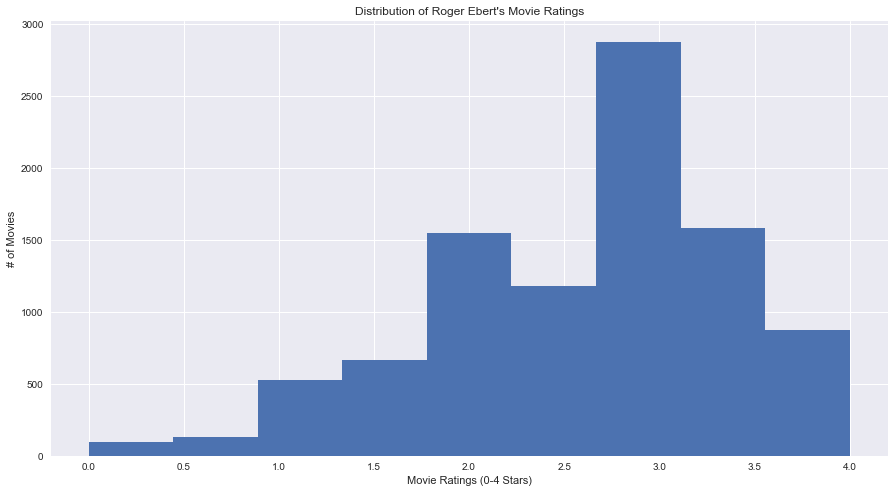

In [19]:
plt.figure(figsize=(15,8))
plt.hist(ebert_imdb_df['EbertStars'], bins = 9)
plt.title("Distribution of Roger Ebert's Movie Ratings")
plt.xlabel('Movie Ratings (0-4 Stars)')
plt.ylabel('# of Movies')

In [20]:
movie_ratings = ebert_imdb_df[['Title', 'EbertStars', 'IMDB_Rating', 'Rating_Count', 
                            'Metascore', 'User_Review_Count', 'Critic_Review_Count']]

movie_ratings = movie_ratings.dropna()

## Pairplot of Numerical Features

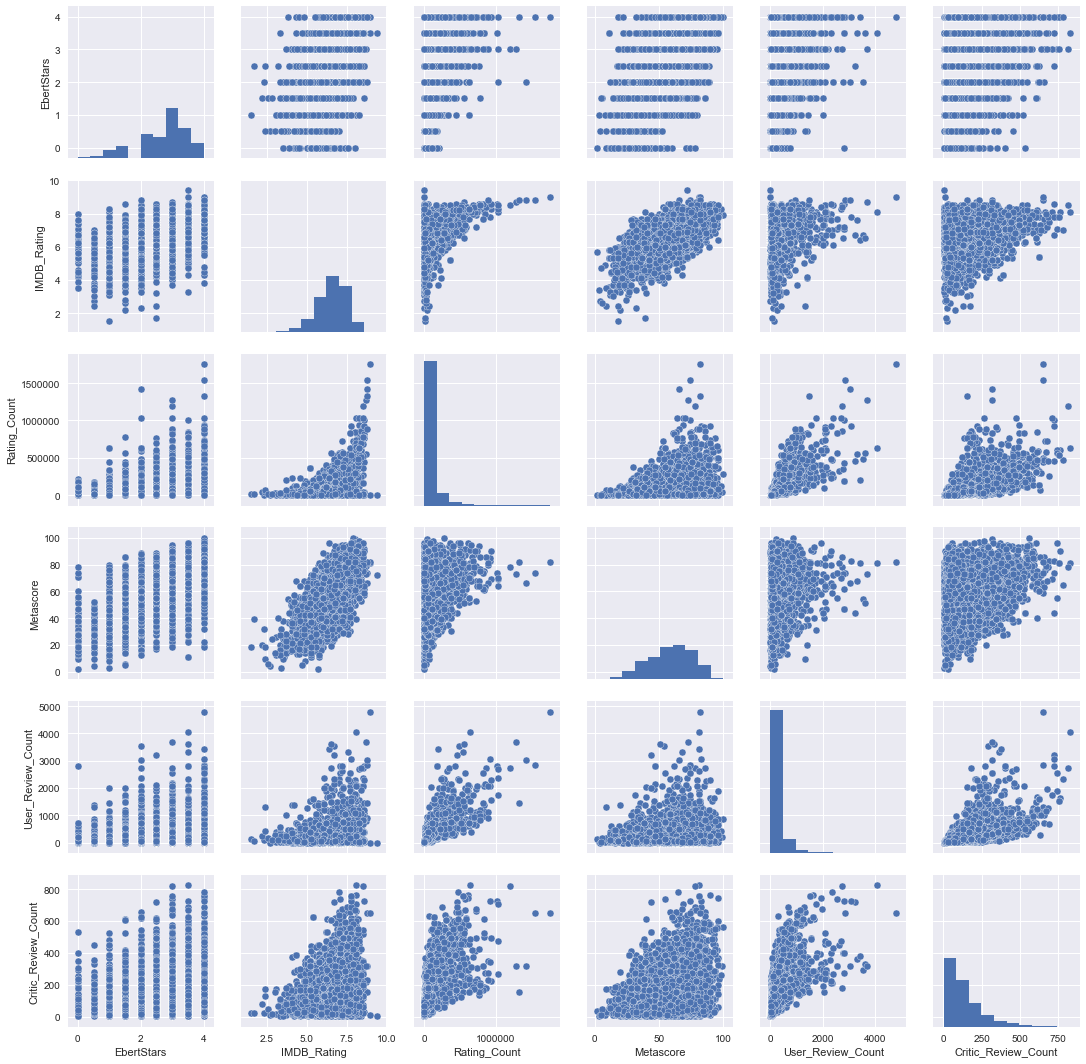

In [33]:
sns.pairplot(movie_ratings[['EbertStars', 'IMDB_Rating', 'Rating_Count', 
                            'Metascore', 'User_Review_Count', 'Critic_Review_Count']])

## Jointplot of IMDB Rating and Ebert Stars

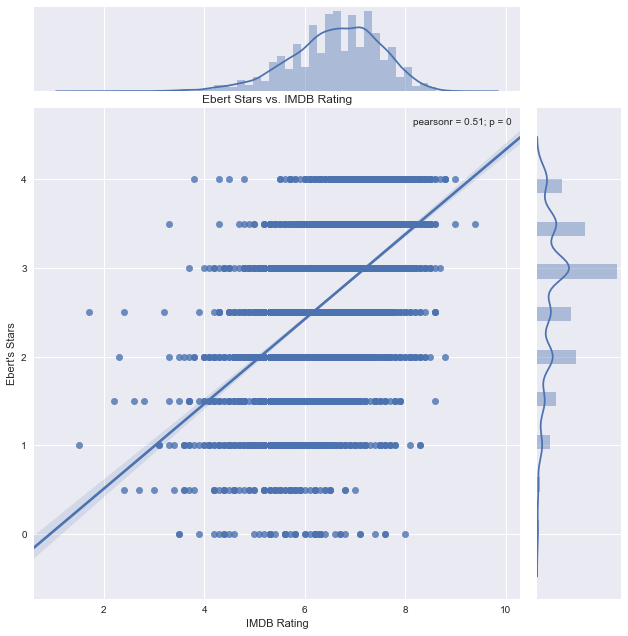

In [34]:
sns.jointplot(x='IMDB_Rating', y='EbertStars', data=movie_ratings, kind='reg', size=9)
plt.xlabel('IMDB Rating')
plt.ylabel("Ebert's Stars")
plt.title('Ebert Stars vs. IMDB Rating')

## Jointplot of Metascore and Ebert Stars

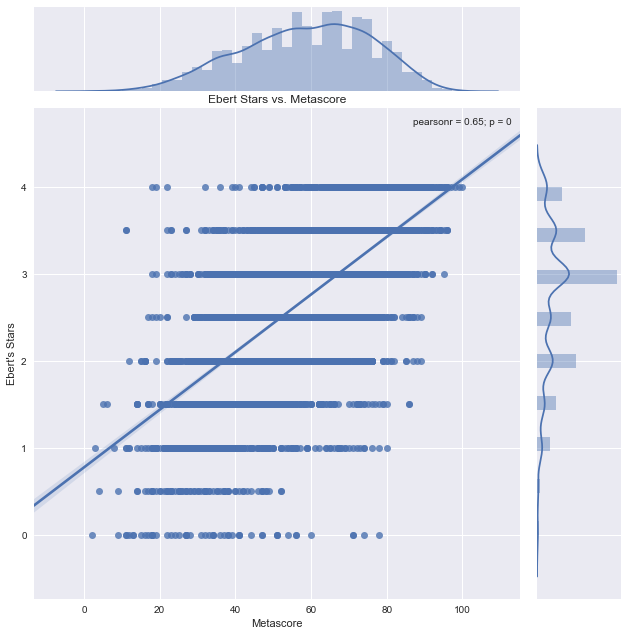

In [35]:
sns.jointplot(x='Metascore', y='EbertStars', data=movie_ratings, kind='reg', size=9)
plt.xlabel('Metascore')
plt.ylabel("Ebert's Stars")
plt.title('Ebert Stars vs. Metascore')

## Jointplot of Number of Ratings and Ebert Stars

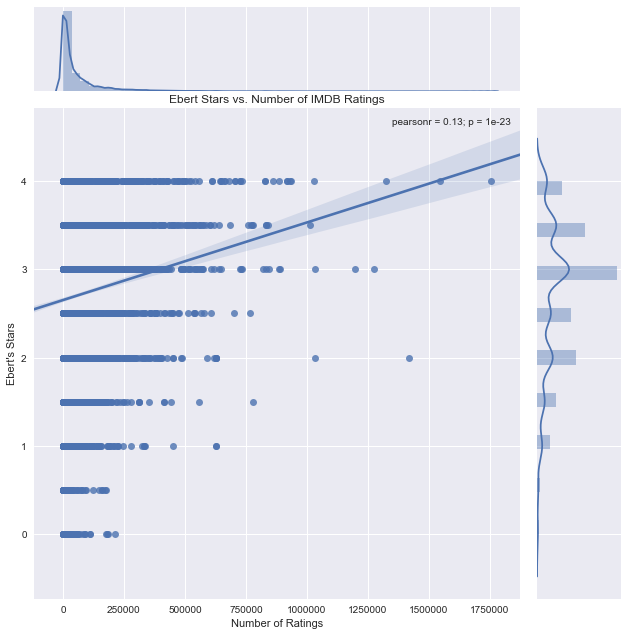

In [36]:
sns.jointplot(x='Rating_Count', y='EbertStars', data=movie_ratings, kind='reg', size=9)
plt.xlabel('Number of Ratings')
plt.ylabel("Ebert's Stars")
plt.title('Ebert Stars vs. Number of IMDB Ratings')

## Jointplot of Number of User Reviews and Ebert Stars

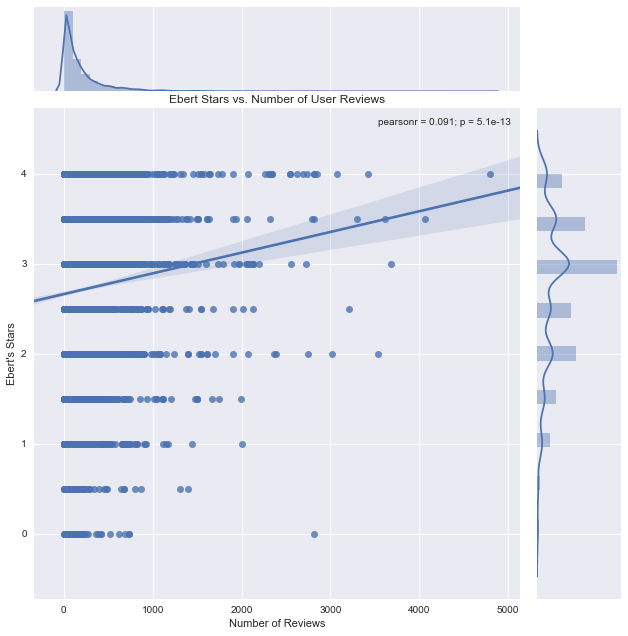

In [37]:
sns.jointplot(x='User_Review_Count', y='EbertStars', data=movie_ratings, kind='reg', size=9)
plt.xlabel('Number of Reviews')
plt.ylabel("Ebert's Stars")
plt.title('Ebert Stars vs. Number of User Reviews')

## Jointplot of Number of Critic Reviews and Ebert Stars

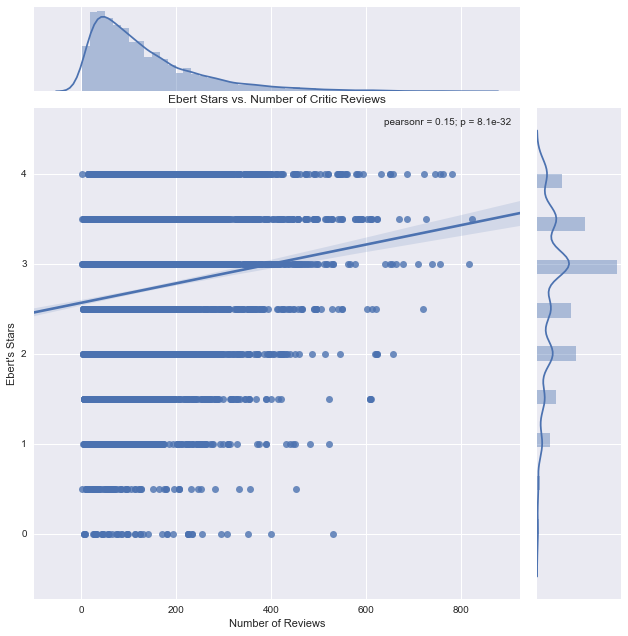

In [35]:
sns.jointplot(x='Critic_Review_Count', y='EbertStars', data=movie_ratings, kind='reg', size=9)
plt.xlabel('Number of Reviews')
plt.ylabel("Ebert's Stars")
plt.title('Ebert Stars vs. Number of Critic Reviews')

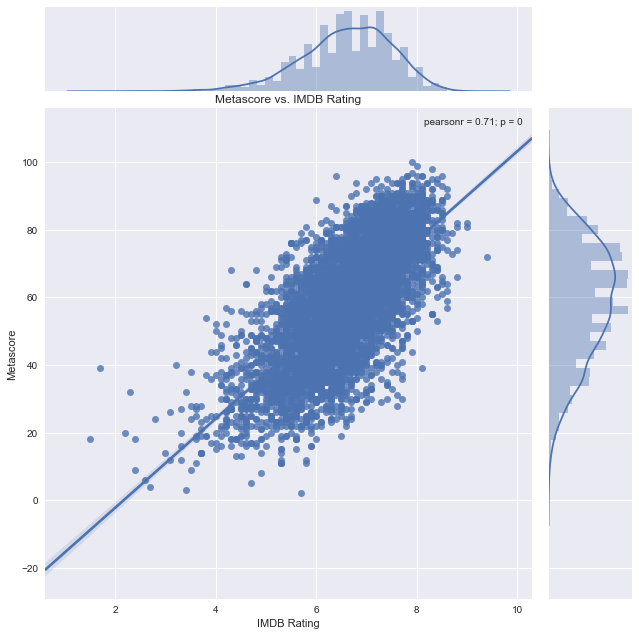

In [36]:
sns.jointplot(x='IMDB_Rating', y='Metascore', data=movie_ratings, kind='reg', size=9)
plt.xlabel('IMDB Rating')
plt.ylabel('Metascore')
plt.title('Metascore vs. IMDB Rating')

## TODO: Add RottenTomatoes data as well

## TODO: Check for and deal with outliers

# Feature Engineering

In [38]:
ebert_imdb_df.head(2)

,Title,IMDB_Rating,Rating_Count,Description,Metascore,User_Review_Count,Critic_Review_Count,Genre_List,Stars_List,Director,Country,Release_Date,EbertStars,Year,URL,Rating,Runtime,Review
0,A Cure for Wellness,6.6,1646.0,"Directed by Gore Verbinski. With Dane DeHaan,...",47.0,16.0,90.0,"Mystery, Thriller","Dane DeHaan,, Jason Isaacs,, Mia Goth",Gore Verbinski,USA,2017-02-17,2.0,2017.0,/reviews/a-cure-for-wellness-2017,R,146.0,I keep forgetting the title of “A Cure for Wel...
1,Big Little Lies,NaN,NaN,"With Alexander Skarsgård, James Tupper, Laura ...",NaN,NaN,90.0,"Comedy, Crime, Drama","Alexander Skarsgård,, James Tupper,, Laura Dern",Alexander Skarsgård,,NaT,3.5,2017.0,/reviews/big-little-lies-2017,NR,420.0,"HBO’s excellent “Big Little Lies,” based on th..."


In [21]:
def check_foreign(row):
    try:
        country = row['Country']

        if country in ['USA', 'UK', 'Canada']:
            return 0
        else:
            return 1
    except:
        return np.nan
    
def user_critic_ratio(row):
    try:
        ratio = row['User_Review_Count'] / row['Critic_Review_Count']
        return ratio
    except:
        return np.nan
    
def description_length(row):
    try:
        length = len(row['Description'].split())
        return length
    except:
        return np.nan
    
def review_length(row):
    try:
        length = len(row['Review'].split())
        return length
    except:
        return np.nan
    
def convert_season(row):
    try:
        day = row['Release_Date'].timetuple().tm_yday
        
        spring = range(80, 172)
        summer = range(172, 264)
        fall = range(264, 355)

        if day in spring:
            season = 'Spring'
        elif day in summer:
            season = 'Summer'
        elif day in fall:
            season = 'Fall'
        else:
            season = 'Winter'
            
        return season
    except:
        return np.nan

In [22]:
ebert_imdb_df['Foreign'] = ebert_imdb_df.apply(lambda x: check_foreign(x), 1)
ebert_imdb_df['UC_Ratio'] = ebert_imdb_df.apply(lambda x: user_critic_ratio(x), 1)
ebert_imdb_df['Description_Len'] = ebert_imdb_df.apply(lambda x: description_length(x), 1)
ebert_imdb_df['Review_Len'] = ebert_imdb_df.apply(lambda x: review_length(x), 1)
ebert_imdb_df['Season'] = ebert_imdb_df.apply(lambda x: convert_season(x), 1)

## TODO: Convert Actors and Genres to Numeric

In [23]:
ebert_imdb_df.head()

,Title,IMDB_Rating,Rating_Count,Description,Metascore,User_Review_Count,Critic_Review_Count,Genre_List,Stars_List,Director,...,Year,URL,Rating,Runtime,Review,Foreign,UC_Ratio,Description_Len,Review_Len,Season
0,A Cure for Wellness,6.6,1646.0,"Directed by Gore Verbinski. With Dane DeHaan,...",47.0,16.0,90.0,"Mystery, Thriller","Dane DeHaan,, Jason Isaacs,, Mia Goth",Gore Verbinski,...,2017.0,/reviews/a-cure-for-wellness-2017,R,146.0,I keep forgetting the title of “A Cure for Wel...,0,0.177778,52,1096,Winter
1,Big Little Lies,NaN,NaN,"With Alexander Skarsgård, James Tupper, Laura ...",NaN,NaN,90.0,"Comedy, Crime, Drama","Alexander Skarsgård,, James Tupper,, Laura Dern",Alexander Skarsgård,...,2017.0,/reviews/big-little-lies-2017,NR,420.0,"HBO’s excellent “Big Little Lies,” based on th...",1,NaN,28,1091,NaN
2,The Great Wall,6.3,14568.0,"Directed by Yimou Zhang. With Matt Damon, Tia...",42.0,96.0,152.0,"Action, Adventure, Fantasy","Matt Damon,, Tian Jing,, Willem Dafoe",Yimou Zhang,...,2017.0,/reviews/the-great-wall-2017,PG-13,103.0,"Chinese/American co-produced action-fantasy ""T...",0,0.631579,36,820,Winter
3,American Fable,6.3,145.0,Directed by Anne Hamilton. With Peyton Kenned...,57.0,1.0,10.0,Thriller,"Peyton Kennedy,, Richard Schiff,, Kip Pardue",Anne Hamilton,...,2017.0,/reviews/american-fable-2017,NR,96.0,11-year-old Gitty (Peyton Kennedy) listens as ...,0,0.100000,82,1115,Winter
4,Lovesong,6.4,153.0,"Directed by So Yong Kim. With Riley Keough, J...",74.0,3.0,14.0,Drama,"Riley Keough,, Jena Malone,, Jessie Ok Gray",So Yong Kim,...,2017.0,/reviews/lovesong-2017,NR,85.0,Whether you find “Lovesong” refreshingly coy a...,0,0.214286,27,958,Winter


In [24]:
df_rating = pd.get_dummies(ebert_imdb_df['Rating'])
df_director = pd.get_dummies(ebert_imdb_df['Director'])
df_season = pd.get_dummies(ebert_imdb_df['Season'])

In [25]:
ebert_imdb_df.shape

(9494, 23)

In [26]:
ebert_imdb_dim_df = pd.concat([ebert_imdb_df, df_rating, df_director, df_season], axis=1)

In [27]:
ebert_imdb_dim_df.shape

(9494, 4485)

In [28]:
ebert_imdb_dim_df = ebert_imdb_dim_df.rename(columns={'PG-13': 'PG_13'})

In [29]:
# baseline model
ebert_imdb_df.EbertStars.mode() 

0    3.0
dtype: float64

In [30]:
ebert_imdb_df.columns

Index(['Title', 'IMDB_Rating', 'Rating_Count', 'Description', 'Metascore',
       'User_Review_Count', 'Critic_Review_Count', 'Genre_List', 'Stars_List',
       'Director', 'Country', 'Release_Date', 'EbertStars', 'Year', 'URL',
       'Rating', 'Runtime', 'Review', 'Foreign', 'UC_Ratio', 'Description_Len',
       'Review_Len', 'Season'],
      dtype='object')

In [31]:
ebert_imdb_df['Season'].value_counts()

Fall      2436
Summer    2065
Spring    2057
Winter    2037
Name: Season, dtype: int64

In [32]:
pickle.dump(ebert_imdb_df, open('ebert_imdb_df.pkl', 'wb'))

In [143]:
ebert_imdb_df = pickle.load(open('ebert_imdb_df.pkl', 'rb'))

# Convert Genres to dummy variables

In [144]:
genre_array = [genre_list.split(",") for genre_list in ebert_imdb_df['Genre_List']]
unique_genres = {genre.strip() for genres in genre_array for genre in genres}
unique_genres.discard('')
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

In [145]:
for genre in sorted(unique_genres):
    ebert_imdb_df[genre] = np.zeros(len(ebert_imdb_df), dtype=int)

In [146]:
pd.set_option("display.max_columns", 150)
ebert_imdb_df.head()

,Title,IMDB_Rating,Rating_Count,Description,Metascore,User_Review_Count,Critic_Review_Count,Genre_List,Stars_List,Director,Country,Release_Date,EbertStars,Year,URL,Rating,Runtime,Review,Foreign,UC_Ratio,Description_Len,Review_Len,Season,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,A Cure for Wellness,6.6,1646.0,"Directed by Gore Verbinski. With Dane DeHaan,...",47.0,16.0,90.0,"Mystery, Thriller","Dane DeHaan,, Jason Isaacs,, Mia Goth",Gore Verbinski,USA,2017-02-17,2.0,2017.0,/reviews/a-cure-for-wellness-2017,R,146.0,I keep forgetting the title of “A Cure for Wel...,0,0.177778,52,1096,Winter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Big Little Lies,NaN,NaN,"With Alexander Skarsgård, James Tupper, Laura ...",NaN,NaN,90.0,"Comedy, Crime, Drama","Alexander Skarsgård,, James Tupper,, Laura Dern",Alexander Skarsgård,,NaT,3.5,2017.0,/reviews/big-little-lies-2017,NR,420.0,"HBO’s excellent “Big Little Lies,” based on th...",1,NaN,28,1091,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Great Wall,6.3,14568.0,"Directed by Yimou Zhang. With Matt Damon, Tia...",42.0,96.0,152.0,"Action, Adventure, Fantasy","Matt Damon,, Tian Jing,, Willem Dafoe",Yimou Zhang,USA,2017-02-17,3.0,2017.0,/reviews/the-great-wall-2017,PG-13,103.0,"Chinese/American co-produced action-fantasy ""T...",0,0.631579,36,820,Winter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,American Fable,6.3,145.0,Directed by Anne Hamilton. With Peyton Kenned...,57.0,1.0,10.0,Thriller,"Peyton Kennedy,, Richard Schiff,, Kip Pardue",Anne Hamilton,USA,2017-02-17,3.0,2017.0,/reviews/american-fable-2017,NR,96.0,11-year-old Gitty (Peyton Kennedy) listens as ...,0,0.100000,82,1115,Winter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Lovesong,6.4,153.0,"Directed by So Yong Kim. With Riley Keough, J...",74.0,3.0,14.0,Drama,"Riley Keough,, Jena Malone,, Jessie Ok Gray",So Yong Kim,USA,2017-02-17,3.0,2017.0,/reviews/lovesong-2017,NR,85.0,Whether you find “Lovesong” refreshingly coy a...,0,0.214286,27,958,Winter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [147]:
# fill the genres with 1's
for idx, row in ebert_imdb_df.iterrows():
    for genre in row['Genre_List'].split(", "):
        if genre != '':
            ebert_imdb_df.ix[idx, genre] = 1

In [148]:
ebert_imdb_df.head()

,Title,IMDB_Rating,Rating_Count,Description,Metascore,User_Review_Count,Critic_Review_Count,Genre_List,Stars_List,Director,Country,Release_Date,EbertStars,Year,URL,Rating,Runtime,Review,Foreign,UC_Ratio,Description_Len,Review_Len,Season,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,A Cure for Wellness,6.6,1646.0,"Directed by Gore Verbinski. With Dane DeHaan,...",47.0,16.0,90.0,"Mystery, Thriller","Dane DeHaan,, Jason Isaacs,, Mia Goth",Gore Verbinski,USA,2017-02-17,2.0,2017.0,/reviews/a-cure-for-wellness-2017,R,146.0,I keep forgetting the title of “A Cure for Wel...,0,0.177778,52,1096,Winter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,Big Little Lies,NaN,NaN,"With Alexander Skarsgård, James Tupper, Laura ...",NaN,NaN,90.0,"Comedy, Crime, Drama","Alexander Skarsgård,, James Tupper,, Laura Dern",Alexander Skarsgård,,NaT,3.5,2017.0,/reviews/big-little-lies-2017,NR,420.0,"HBO’s excellent “Big Little Lies,” based on th...",1,NaN,28,1091,NaN,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The Great Wall,6.3,14568.0,"Directed by Yimou Zhang. With Matt Damon, Tia...",42.0,96.0,152.0,"Action, Adventure, Fantasy","Matt Damon,, Tian Jing,, Willem Dafoe",Yimou Zhang,USA,2017-02-17,3.0,2017.0,/reviews/the-great-wall-2017,PG-13,103.0,"Chinese/American co-produced action-fantasy ""T...",0,0.631579,36,820,Winter,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,American Fable,6.3,145.0,Directed by Anne Hamilton. With Peyton Kenned...,57.0,1.0,10.0,Thriller,"Peyton Kennedy,, Richard Schiff,, Kip Pardue",Anne Hamilton,USA,2017-02-17,3.0,2017.0,/reviews/american-fable-2017,NR,96.0,11-year-old Gitty (Peyton Kennedy) listens as ...,0,0.100000,82,1115,Winter,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Lovesong,6.4,153.0,"Directed by So Yong Kim. With Riley Keough, J...",74.0,3.0,14.0,Drama,"Riley Keough,, Jena Malone,, Jessie Ok Gray",So Yong Kim,USA,2017-02-17,3.0,2017.0,/reviews/lovesong-2017,NR,85.0,Whether you find “Lovesong” refreshingly coy a...,0,0.214286,27,958,Winter,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [149]:
pickle.dump(ebert_imdb_df, open('ebert_imdb_df_v2.pkl', 'wb'))

In [150]:
ebert_imdb_df = pickle.load(open('ebert_imdb_df_v2.pkl', 'rb'))

# More EDA

In [197]:
genre_counts = pd.Series(index=unique_genres, dtype=int)

for genre in unique_genres:
    genre_counts[genre] = len(ebert_imdb_df[ebert_imdb_df[genre] == 1])
    
genre_counts.sort_values(ascending=False, inplace=True)

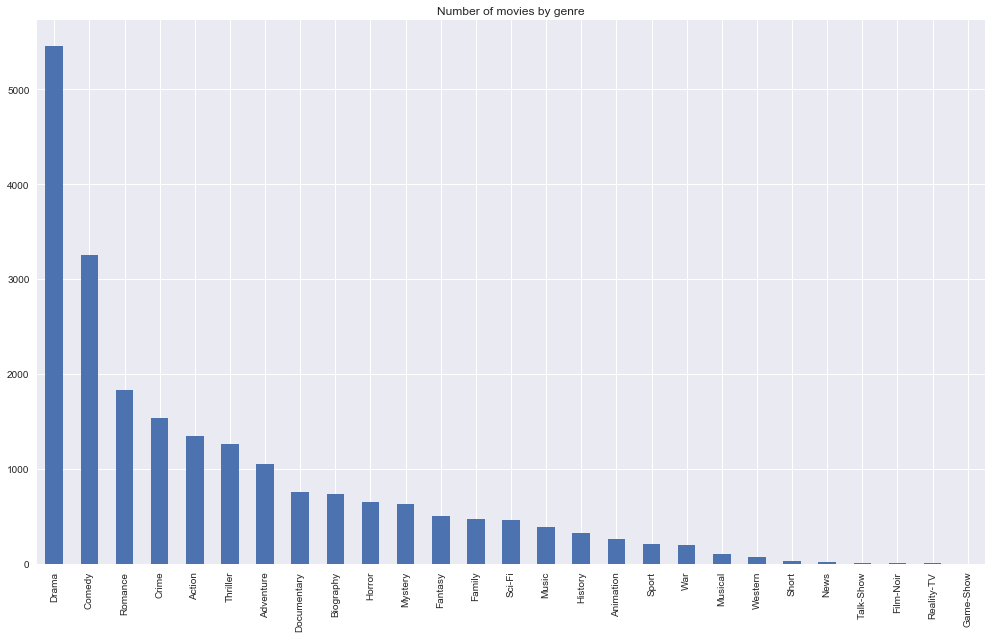

In [201]:
genre_counts.plot.bar(figsize=(17, 10), title="Number of movies by genre")

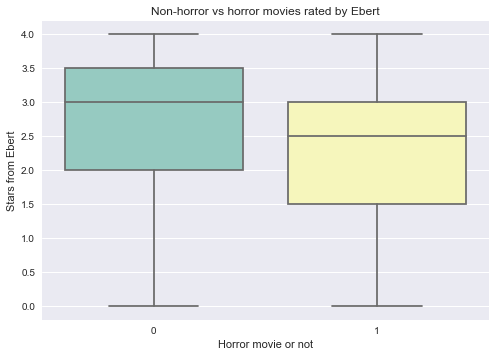

In [219]:
sns.boxplot(x="Horror", y="EbertStars", data=ebert_imdb_df, palette="Set3")
plt.xlabel('Horror movie or not')
plt.ylabel('Stars from Ebert')
plt.title('Non-horror vs horror movies rated by Ebert')

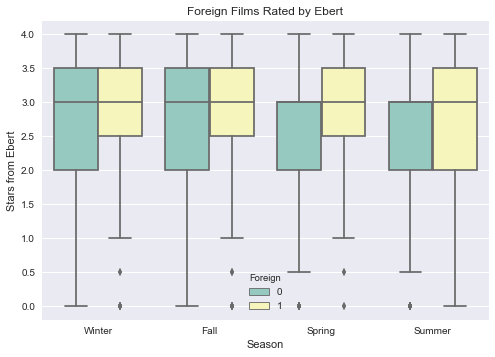

In [49]:
sns.boxplot(x="Season", y="EbertStars", hue="Foreign", data=ebert_imdb_df, palette="Set3")
plt.xlabel('Season')
plt.ylabel('Stars from Ebert')
plt.title('Foreign Films Rated by Ebert')

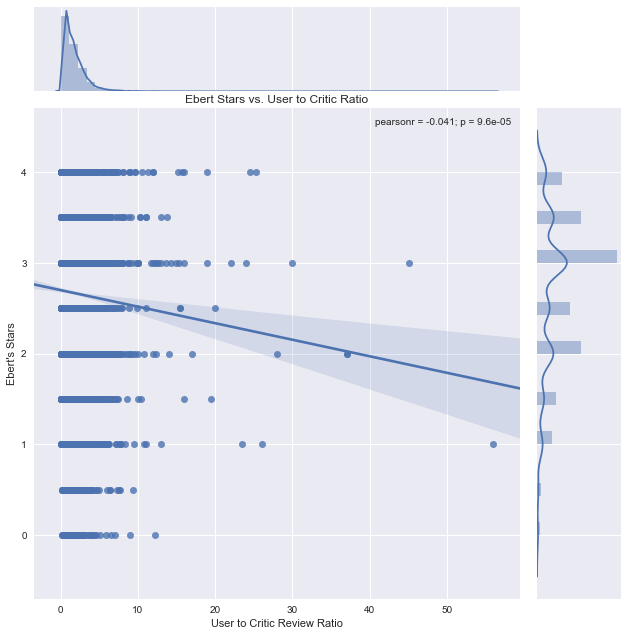

In [50]:
sns.jointplot(x='UC_Ratio', y='EbertStars', data=ebert_imdb_df, kind='reg', size=9)
plt.xlabel('User to Critic Review Ratio')
plt.ylabel("Ebert's Stars")
plt.title('Ebert Stars vs. User to Critic Ratio')

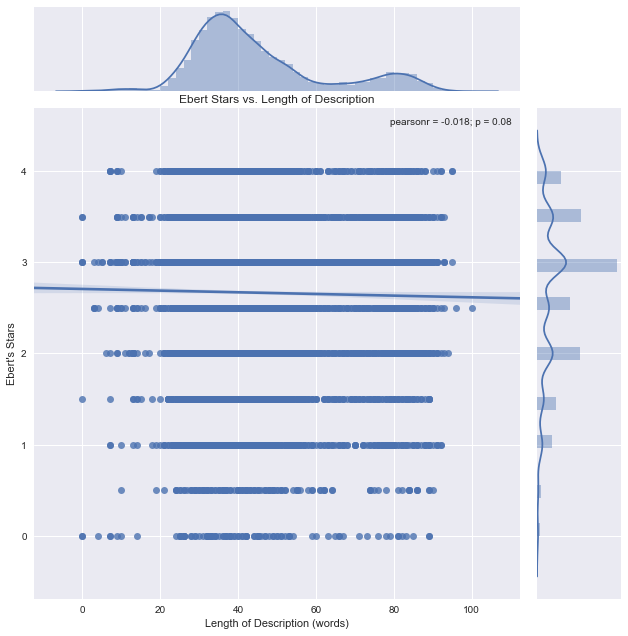

In [51]:
sns.jointplot(x='Description_Len', y='EbertStars', data=ebert_imdb_df, kind='reg', size=9)
plt.xlabel('Length of Description (words)')
plt.ylabel("Ebert's Stars")
plt.title('Ebert Stars vs. Length of Description')

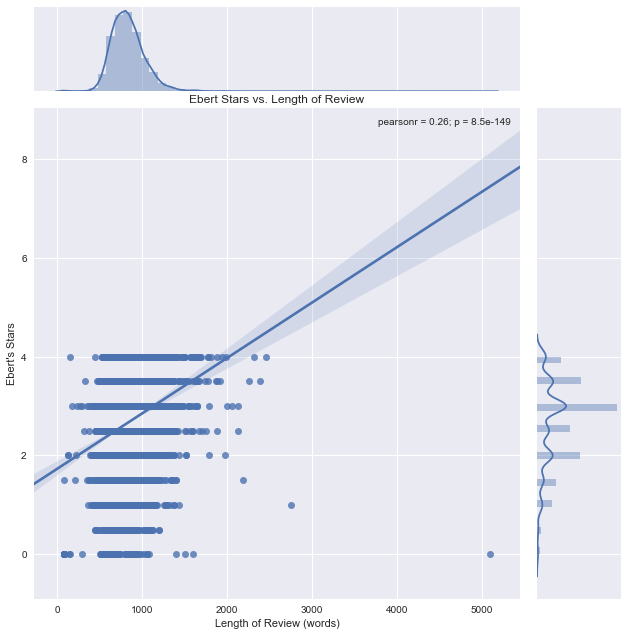

In [52]:
sns.jointplot(x='Review_Len', y='EbertStars', data=ebert_imdb_df, kind='reg', size=9)
plt.xlabel('Length of Review (words)')
plt.ylabel("Ebert's Stars")
plt.title('Ebert Stars vs. Length of Review')

# Modeling (without genres)

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [220]:
ebert_imdb_df.columns

Index(['Title', 'IMDB_Rating', 'Rating_Count', 'Description', 'Metascore',
       'User_Review_Count', 'Critic_Review_Count', 'Genre_List', 'Stars_List',
       'Director', 'Country', 'Release_Date', 'EbertStars', 'Year', 'URL',
       'Rating', 'Runtime', 'Review', 'Foreign', 'UC_Ratio', 'Description_Len',
       'Review_Len', 'Season', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western'],
      dtype='object')

In [55]:
regression_df = ebert_imdb_df[['Title', 'IMDB_Rating', 'Rating_Count', 'Metascore',
       'User_Review_Count', 'Critic_Review_Count', 'Year', 'EbertStars', 'Runtime', 
        'Foreign', 'UC_Ratio', 'Description_Len', 'Review_Len', 'Season']]

In [56]:
df_season = pd.get_dummies(regression_df['Season'])
regression_df = pd.concat([regression_df, df_season], axis=1)

In [57]:
regression_df = regression_df.dropna()

In [58]:
train, test = train_test_split(regression_df, test_size=0.33, random_state=42)

In [251]:
def half_round(x, prec=1, base=.5):
    return round(base * round(float(x) / base), prec)

## Baseline Model

In [60]:
y_test = test['EbertStars']
baseline = [3.0] * len(y_test)

In [61]:
baseline_error = mean_squared_error(y_test, baseline)
print('Baseline Algorithm Error: ', baseline_error)

Baseline Algorithm Error:  0.83736349454


## TODO: Dimensionality Reduction with Genres, Actors and Directors

## Regression Model

In [62]:
X = train.drop(['Season', 'Title', 'Year', 'EbertStars'], axis=1)
y = train['EbertStars']

In [63]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.params)
results.summary()

const                 -1.287586e-01
IMDB_Rating            7.534732e-02
Rating_Count          -8.375849e-08
Metascore              2.852019e-02
User_Review_Count     -1.732272e-04
Critic_Review_Count    1.204426e-04
Runtime                2.640074e-03
Foreign               -1.572688e-02
UC_Ratio               3.777512e-02
Description_Len       -5.829899e-04
Review_Len             5.256826e-04
Fall                  -3.972394e-02
Spring                -3.368535e-02
Summer                -3.298553e-02
Winter                -2.236381e-02
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EbertStars   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     238.7
Date:                Mon, 08 May 2017   Prob (F-statistic):               0.00
Time:                        20:16:44   Log-Likelihood:                -3778.6
No. Observations:                3904   AIC:                             7585.
Df Residuals:                    3890   BIC:                             7673.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1288      0.085     -1.510      0.131      -0.296       0.038
IMDB_Rating             0.0753      0.018      4.284      0.000       0.041       0.110
Rating_Count        -8.376e-08   1.54e-07     -0.546      0.585   -3.85e-07    2.17e-07
Metascore               0.0285      0.001     32.095      0.000       0.027       0.030
User_Review_Count      -0.0002   7.46e-05     -2.322      0.020      -0.000   -2.69e-05
Critic_Review_Count     0.0001      0.000      0.812      0.417      -0.000       0.000
Runtime                 0.0026      0.001      4.238      0.000       0.001       0.004
Foreign                -0.0157      0.029     -0.552      0.581      -0.072       0.040
UC_Ratio                0.0378      0.013      2.855      0.004       0.012       0.064
Description_Len        -0.0006      0.001     -0.800      0.424      -0.002       0.001
Review_Len              0.0005   5.45e-05      9.639      0.000       0.000       0.001
Fall                   -0.0397      0.028     -1.412      0.158      -0.095       0.015
Spring                 -0.0337      0.027     -1.235      0.217      -0.087       0.020
Summer                 -0.0330      0.027     -1.235      0.217      -0.085       0.019
Winter                 -0.0224      0.029     -0.770      0.441      -0.079       0.035
==============================================================================
Omnibus:                      230.502   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.163
Skew:                          -0.524   Prob(JB):                     4.06e-71
Kurtosis:                       3.945   Cond. No.                     1.12e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.22e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [64]:
X = test.drop(['Season', 'Title', 'Year', 'EbertStars'], axis=1)
y = test['EbertStars']

In [65]:
predictions = results.predict(sm.add_constant(X))
y_round = [half_round(y) for y in predictions]
print('Linear Regression Error: ', mean_squared_error(y, y_round))

Linear Regression Error:  0.417446697868


## Predict post-Ebert movies (instead of random train / test split)

In [66]:
post_ebert = regression_df[regression_df['Year'] >= 2013]
pre_ebert = regression_df[regression_df['Year'] < 2013]

In [67]:
print(post_ebert.shape)
print(pre_ebert.shape)

(1899, 18)
(3928, 18)


In [68]:
X = pre_ebert.drop(['Season', 'Title', 'Year', 'EbertStars'], axis=1)
y = pre_ebert['EbertStars']

In [69]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.params)
results.summary()

const                 -1.307500e-01
IMDB_Rating            8.916902e-02
Rating_Count          -1.322353e-07
Metascore              2.519377e-02
User_Review_Count     -4.146950e-05
Critic_Review_Count    9.131121e-05
Runtime                1.465926e-03
Foreign               -7.717471e-02
UC_Ratio              -4.828906e-02
Description_Len       -6.037064e-04
Review_Len             1.063082e-03
Fall                  -2.654290e-02
Spring                -6.272251e-02
Summer                -4.101069e-03
Winter                -3.738353e-02
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EbertStars   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     249.2
Date:                Mon, 08 May 2017   Prob (F-statistic):               0.00
Time:                        20:17:06   Log-Likelihood:                -3639.0
No. Observations:                3928   AIC:                             7306.
Df Residuals:                    3914   BIC:                             7394.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.1308      0.084     -1.548      0.122      -0.296       0.035
IMDB_Rating             0.0892      0.017      5.125      0.000       0.055       0.123
Rating_Count        -1.322e-07   1.29e-07     -1.027      0.304   -3.85e-07     1.2e-07
Metascore               0.0252      0.001     28.564      0.000       0.023       0.027
User_Review_Count   -4.147e-05   6.78e-05     -0.612      0.541      -0.000    9.14e-05
Critic_Review_Count  9.131e-05      0.000      0.590      0.555      -0.000       0.000
Runtime                 0.0015      0.001      2.432      0.015       0.000       0.003
Foreign                -0.0772      0.028     -2.726      0.006      -0.133      -0.022
UC_Ratio               -0.0483      0.013     -3.808      0.000      -0.073      -0.023
Description_Len        -0.0006      0.001     -0.882      0.378      -0.002       0.001
Review_Len              0.0011   6.26e-05     16.988      0.000       0.001       0.001
Fall                   -0.0265      0.028     -0.965      0.335      -0.080       0.027
Spring                 -0.0627      0.026     -2.370      0.018      -0.115      -0.011
Summer                 -0.0041      0.026     -0.157      0.875      -0.055       0.047
Winter                 -0.0374      0.028     -1.314      0.189      -0.093       0.018
==============================================================================
Omnibus:                      269.484   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              393.342
Skew:                          -0.572   Prob(JB):                     3.86e-86
Kurtosis:                       4.047   Cond. No.                     1.02e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.86e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [70]:
X = post_ebert.drop(['Season', 'Title', 'Year', 'EbertStars'], axis=1)
y = post_ebert['EbertStars']

In [71]:
predictions = results.predict(sm.add_constant(X))
y_round = [half_round(y) for y in predictions]
print('Linear Regression Error: ', mean_squared_error(y, y_round))

Linear Regression Error:  0.614533965245


# Modeling (with Genres)

In [244]:
# regression_genre_df = ebert_imdb_df[['Title', 'IMDB_Rating', 'Rating_Count', 'Metascore',
#        'User_Review_Count', 'Critic_Review_Count', 'Year', 'EbertStars', 'Runtime', 
#        'Foreign', 'UC_Ratio', 'Description_Len', 'Review_Len', 'Season', 'Action', 
#        'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
#        'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music',
#        'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
#        'Talk-Show', 'Thriller', 'War', 'Western']]

regression_genre_df = ebert_imdb_df[['Title', 'IMDB_Rating', 'Metascore',
       'Year', 'EbertStars', 'Runtime', 
       'Foreign',
       'Animation', 'Crime', 'Drama', 'Fantasy', 'Horror', 'Mystery']]

#df_season = pd.get_dummies(regression_genre_df['Season'])
#regression_genre_df = pd.concat([regression_genre_df, df_season], axis=1)
regression_genre_df = regression_genre_df.dropna()

In [245]:
train, test = train_test_split(regression_genre_df, test_size=0.33, random_state=42)
#X = train.drop(['Season', 'Title', 'Year', 'EbertStars'], axis=1)
X = train.drop(['Title', 'Year', 'EbertStars'], axis=1)
y = train['EbertStars']

In [246]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             EbertStars   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     327.4
Date:                Mon, 15 May 2017   Prob (F-statistic):               0.00
Time:                        21:48:28   Log-Likelihood:                -3906.7
No. Observations:                4017   AIC:                             7835.
Df Residuals:                    4006   BIC:                             7905.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1646      0.089      1.859      0.063      -0.009       0.338
IMDB_Rating     0.0565      0.016      3.531      0.000       0.025       0.088
Metascore       0.0307      0.001     36.062      0.000       0.029       0.032
Runtime         0.0031      0.001      5.426      0.000       0.002       0.004
Foreign        -0.0885      0.026     -3.347      0.001      -0.140      -0.037
Animation       0.0837      0.057      1.457      0.145      -0.029       0.196
Crime           0.0729      0.028      2.637      0.008       0.019       0.127
Drama           0.1097      0.022      4.990      0.000       0.067       0.153
Fantasy         0.1115      0.046      2.433      0.015       0.022       0.201
Horror         -0.1130      0.042     -2.705      0.007      -0.195      -0.031
Mystery         0.0758      0.041      1.870      0.062      -0.004       0.155
==============================================================================
Omnibus:                      200.386   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.414
Skew:                          -0.452   Prob(JB):                     5.25e-64
Kurtosis:                       3.960   Cond. No.                     1.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [249]:
#X = test.drop(['Season', 'Title', 'Year', 'EbertStars'], axis=1)
X = test.drop(['Title', 'Year', 'EbertStars'], axis=1)
y = test['EbertStars']

In [252]:
predictions = results.predict(sm.add_constant(X))
y_round = [half_round(y) for y in predictions]
print('Linear Regression Error: ', mean_squared_error(y, y_round))

Linear Regression Error:  0.41649823143


## TODO: Check Regression Assumptions (ie. Multicollinearity / Heteroskedasticity)

## TODO: Run Various other Model Configurations / Setup a Pythonic Feature Selection

In [371]:
# If you add in dummy variables for Genre, R^2 will go much higher, closer to 0.9

## TODO: How good is the model? How significant is the model? How significant are the coefficients?

# Visuals

## TODO: Look at what model is good at predicting, bad at predicting and whether it over or under predicts

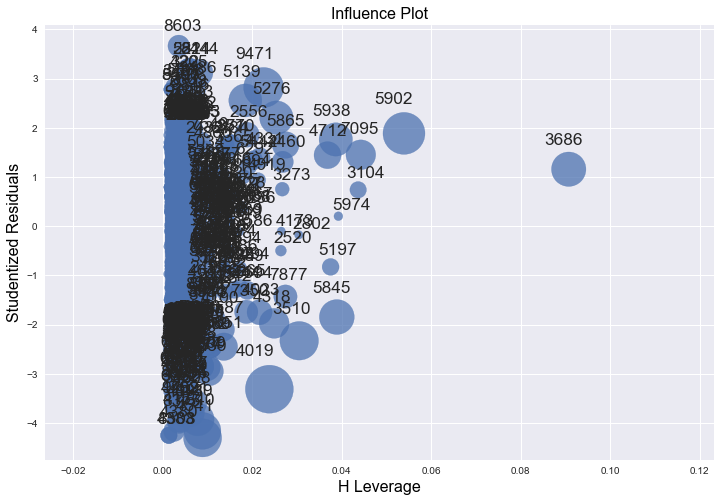

In [72]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(results, ax=ax, criterion="cooks")

There are a few worrisome observations. 3686 has small residule and large leverage. Several other points seem to have high positive or negative residuals as less (greater than or less than -2/+2)

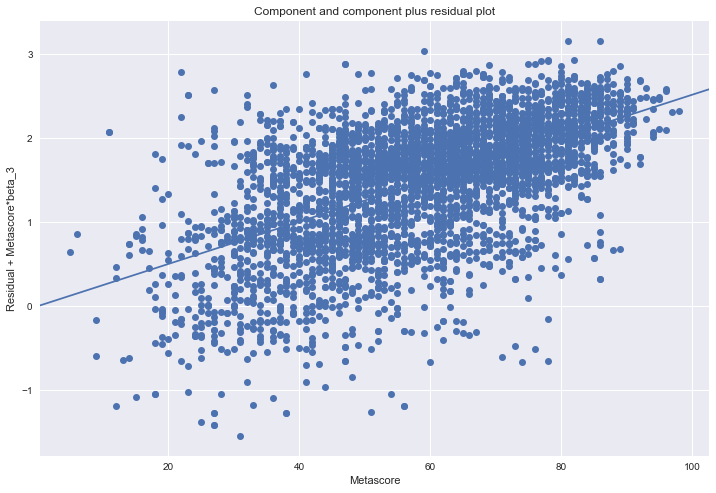

In [73]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_ccpr(results, "Metascore", ax=ax)

As you can see, the relationship between Ebert Stars explained by Metascore conditional on the other variables seems to be linear, though there are several other observations that are exerting considerable influence on the relationship.

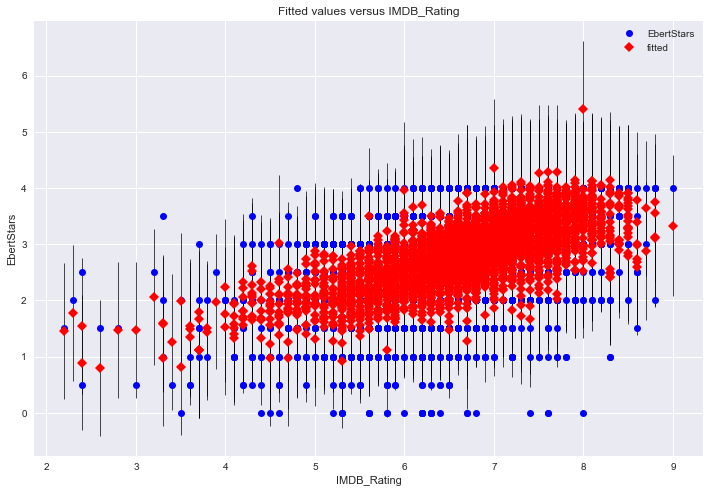

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(results, "IMDB_Rating", ax=ax)

We can see the fitted values vs. a choosen independent variable, which in this case is IMDB Rating. You can see the prediction confidence intervals as well.

# Conclusions, Lessons Learned and Further Research

In [374]:
## See README

# Grade - C

# Future Update

- Non-linear Regression
- Regularization
- Cross-validation and Resampling methods